Nonlinear dynamics:

$\dot{x}_1 = \mu x_1$

$\dot{x}_2 = \lambda (x_2 - x^2_1)$

Koopman linear system:

$\frac{d}{dt} 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix} = 
\begin{bmatrix} \mu & 0 & 0 \\ 0 & \lambda & - \lambda \\ 0 & 0 & -2 \lambda \end{bmatrix}
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix}
for \begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix} = \begin{bmatrix} x_1 \\ x_2 \\ x^2_1 \end{bmatrix} $

Dynamics with inputs:

$\frac{d}{dt} 
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = 
\begin{bmatrix} \mu & 0 \\ 0 & \lambda \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} +
\begin{bmatrix} 0 \\ - \lambda x^2_1 \end{bmatrix} +
\begin{bmatrix} 0 \\ 1 \end{bmatrix} u 
$

Koopman linear system with inputs:

$\frac{d}{dt} 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix} = 
\begin{bmatrix} \mu & 0 & 0 \\ 0 & \lambda & - \lambda \\ 0 & 0 & -2 \lambda \end{bmatrix}
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}u
$

LQR Cost function:

$
J = \int\limits_0^ \infty \mathbf{x}^T(\tau) \mathbf{Q} \mathbf{x}(\tau) + 
\mathbf{u}^T(\tau) \mathbf{R} \mathbf{u}(\tau) d\tau
$

Nonlinear optimal controller:

$
u = - \begin{bmatrix} \tilde{K}_1 & \tilde{K}_2 \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} - \tilde{K}_3 x^2_1
$


In [2]:
#library import
import control.matlab as ct
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

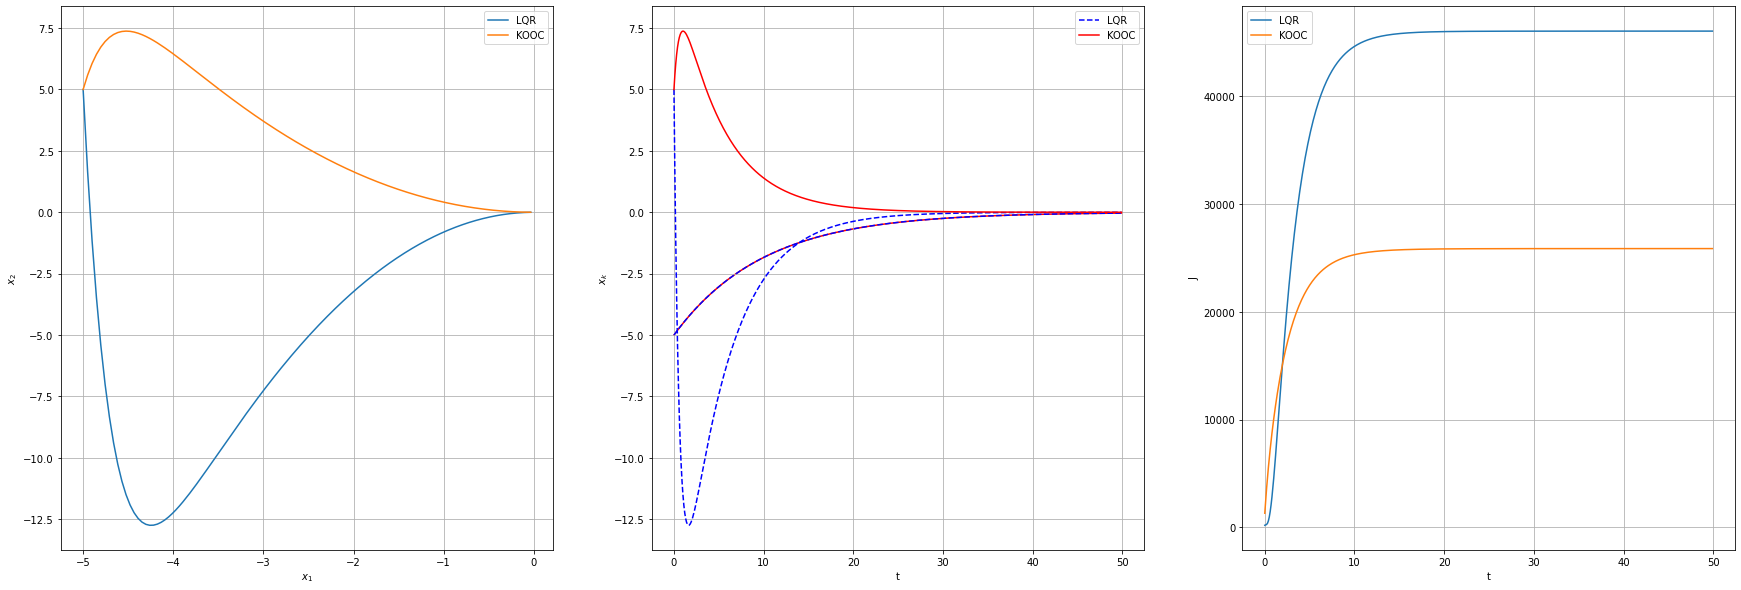

In [3]:
#systems definition
mu = - .1
lmbda = 1

A = np.array([[mu, 0],[0, lmbda]])
B = np.array([[0], [1]])

A1 = np.array([[mu, 0, 0], [0, lmbda, -lmbda],[0, 0, 2*mu]])
B1 = np.array([[0],[1],[0]])

#ODE function
def Sys(state, t, u, mu, lmbda):
    x1 = state[0]
    x2 = state[1]
    dx1 = mu* x1
    dx2 = lmbda*(x2 - x1**2) + u
    return dx1, dx2

#LQR synthesis
Q = np.eye(2)
R = 1
Q1 = np.eye(3)

sys = ct.ss(A, B, np.zeros(2), 0)
K, S, E = ct.lqr(sys, Q, R)

sys1 = ct.ss(A1, B1, np.zeros(3), 0)
K1, S1, E1 = ct.lqr(sys1, Q1, R)

#simulation preparation
dt = .1
t = np.arange(0, 50, dt)
x0 = [-5,5]
x = np.zeros((len(t), len(x0)))
x1 = np.zeros((len(t), len(x0)))
x[0,:] = x0
x1[0,:] = x0
u = np.zeros(len(t))
u1 = np.zeros(len(t))

#simulation
for i in range(len(t)-1):
    ts = [t[i], t[i+1]]
    u[i] = - K @ x[i,:]
    u1[i] = -K1[0,0:2] @ x1[i,:] - K1[0,2]*x1[i,0]**2
    result = odeint(Sys, x[i,:], ts, args = (u[i], mu, lmbda))
    result1 = odeint(Sys, x1[i,:], ts, args = (u1[i], mu, lmbda))
    x[i+1,:] = result[-1,:]
    x1[i+1,:] = result1[-1,:]
    
#ploting results
fig, axs = plt.subplots(1, 3, figsize=(30,10))
axs[0].plot(x[:,0], x[:,1], label='LQR')
axs[0].plot(x1[:,0], x1[:,1], label='KOOC')
axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[0].grid()
axs[0].legend()
axs[1].plot(t, x[:,0], linestyle='--', color='blue', label='LQR', zorder=2)
axs[1].plot(t, x1[:,0], color='red', label='KOOC', zorder=1)
axs[1].plot(t, x[:,1], linestyle='--', color='blue')
axs[1].plot(t, x1[:,1], color='red')
axs[1].set_xlabel('t')
axs[1].set_ylabel('$x_k$')
axs[1].grid()
axs[1].legend()

J = np.zeros(len(t))
J1 = np.zeros(len(t))
y = np.column_stack((x1,x1[:,0]**2))

for i in range(len(t)):
    J[i] = x[i,:].T @ Q @ x[i,:] + R * u[i]**2
    J[i] = J[i] + J[i-1]
    J1[i] = y[i,:].T @ Q1 @ y[i,:] + R * u1[i]**2
    J1[i] = J1[i] + J1[i-1]    

axs[2].plot(t, J, label='LQR')
axs[2].plot(t, J1, label='KOOC')
axs[2].set_xlabel('t')
axs[2].set_ylabel('J')
axs[2].grid()
axs[2].legend()